
<div align="center">
  <img src="https://www.dropbox.com/s/vold2f3fm57qp7g/ECE4179_5179_6179_banner.png?dl=1" alt="ECE4179/5179/6179 Banner" style="max-width: 60%;"/>
</div>

<div align="center">

# Computer Vision

</div>

Welcome to week nine of ECE4179/5179/6179! Vision is arguably the most powerful sense humans rely on to understand, and interact with the world. Approximately **80% of all sensory input** to the brain comes from vision, allowing us to learn, interpret, and make decisions. From recognizing faces to navigating complex environments, vision provides unparalleled access to rich information. Studying **computer vision** enables us to replicate this extraordinary capability in machines, allowing them to understand and process information at massive scales. By teaching machines to "see," we open the door to innovations in fields like robotics, healthcare, autonomous driving, and even daily consumer experiences, fundamentally transforming how technology interacts with the world.

In this workshop, we will have fun by exploring the world of **computer vision**, learning about some essential ideas and techniques, along with putting state-of-the-art models into action. 

### 1. **Object Detection (OD)**
We begin with **Object Detection (OD)**, a fundamental task in computer vision that involves identifying multiple objects in an image and predicting their locations. Unlike traditional classification, OD requires a model to detect unknown numbers of objects and their spatial positions. One of the major breakthroughs in this field was the introduction of **anchor boxes**, which we will discuss.

We’ll examine the architecture and working principles of models like **YOLO (You Only Look Once)**, which led to real-time object detection. We’ll also explore how transformer-based models like **DETR (DEtection TRansformer)** improved upon the idea of anchor boxes.

### 2. **Image Segmentation**
Next, we shift our focus to **Image Segmentation**, where the goal is to label every pixel in an image, either with a semantic category or as part of a distinct object. This enables more granular understanding of an image beyond simple object detection. 

We will explore **semantic segmentation** (assigning a class label to each pixel) and **instance segmentation** (distinguishing between individual instances of the same class). A leading model in this space is **U-Net**, renowned for its ability to capture fine details while maintaining context across the image. 

We will also look at **MaskFormer**, a modern segmentation model that leverages transformers to unify semantic and instance segmentation into a single framework, pushing the boundaries of segmentation performance.

### 3. **Vision-Language Models**
Finally, we will explore the frontier of **vision-language models**, where images and text come together. These models are capable of understanding both visual and textual inputs, leading to powerful applications like zero-shot learning and cross-modal understanding.

We’ll delve into the architecture of **CLIP (Contrastive Language-Image Pretraining)**, which bridges the gap between vision and language, enabling image classification based on text descriptions without additional fine-tuning. Furthermore, we’ll look at **BLIP (Bootstrapped Language-Image Pretraining)**, and **OWL-ViT (Open-World Vision Transformer)**, a model that excels at open-world object detection—capable of detecting objects that weren’t seen during training.

Let's get started! 🚀

In [23]:
# You are strongly encouraged to create a new virtual environment for this project.
# This ensures that all dependencies are properly managed, and it avoids conflicts with other projects.

# You can create a virtual environment using either `conda` or `venv`.
# For conda (recommended), use Python 3.11:
#     conda create -n ECE4179_CV python=3.11
# For venv, use:
#     python -m venv ECE4179_CV

# Import necessary libraries.
# We will use PyTorch for the deep learning models, and Matplotlib for visualization.
# We will also use transformers from the Hugging Face library for our tasks.


import numpy as np
import requests
import pandas as pd
import datetime
from io import BytesIO  # Used for handling byte streams when fetching images from URLs

from PIL import Image  # Pillow for image processing
import matplotlib.pyplot as plt  # For visualizing images
from matplotlib import patches  # For adding shapes (like bounding boxes) to plots

import torch  # PyTorch, our main framework for ML models
import torch.nn.functional as F  # Functional module for operations that don't have any parameters


# !pip install opencv-python
import cv2  # OpenCV for image processing

# Set a random seed to ensure reproducibility
RND_SEED = 42
np.random.seed(RND_SEED)

# Set the device for computation
# We check if Apple's Metal Performance Shaders (MPS) are available (for M1 and later chips)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device (Apple Silicon GPU).")
# If MPS is not available, check for CUDA (for Nvidia GPUs)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device (Nvidia GPU).")
# If neither MPS nor CUDA is available, fall back to CPU
else:
    device = torch.device("cpu")
    print("Using CPU device.")

Using CUDA device (Nvidia GPU).


In [24]:
def plot_results(image, results, class_names, show=True):
    """
    Visualize the detection results by plotting bounding boxes and labels on the image.
    Returns the image with bounding boxes as a NumPy array. Optionally display the plot.
    """

    # Convert image to NumPy array if it's a PIL image
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(1, figsize=(12, 8))

    # Display the input image
    ax.imshow(image)

    # Turn off the axis lines and labels for a cleaner look
    ax.axis("off")

    # Ensure 'boxes', 'scores', and 'labels' are NumPy arrays
    def to_numpy(tensor):
        """Converts a tensor to NumPy if it's not already. Checks if .detach() is needed."""
        if isinstance(tensor, torch.Tensor):
            return (
                tensor.detach().cpu().numpy()
            )  # Detach if tensor requires gradient or is on a device
        return tensor  # If already NumPy, return as is

    # Extract bounding boxes, confidence scores, and class labels, ensuring they are NumPy arrays
    boxes = to_numpy(results["boxes"])
    scores = to_numpy(results["scores"])
    labels = to_numpy(results["labels"])

    # Predefined color palette
    COLORS = [
        "red",
        "blue",
        "green",
        "purple",
        "orange",
        "cyan",
        "magenta",
        "yellow",
        "brown",
        "pink",
        "lime",
        "teal",
        "lavender",
        "turquoise",
        "tan",
        "gold",
        "lightblue",
        "gray",
        "olive",
        "maroon",
        "navy",
        "aqua",
        "silver",
        "coral",
        "fuchsia",
        "khaki",
        "plum",
        "indigo",
        "violet",
        "lightgreen",
        "salmon",
        "beige",
        "darkgreen",
        "darkred",
        "darkblue",
        "sandybrown",
        "darkorange",
        "darkcyan",
        "crimson",
        "orchid",
        "darkslategray",
        "tomato",
        "limegreen",
        "dodgerblue",
        "forestgreen",
        "firebrick",
        "lightcoral",
        "mediumorchid",
        "chocolate",
        "darkgoldenrod",
        "deepskyblue",
        "springgreen",
        "seagreen",
        "powderblue",
        "palevioletred",
        "darkseagreen",
        "mediumslateblue",
        "chartreuse",
        "lightseagreen",
        "darkorchid",
        "hotpink",
        "peachpuff",
        "royalblue",
        "mediumturquoise",
        "lightpink",
        "midnightblue",
        "slategray",
        "rosybrown",
        "lightgray",
        "palegreen",
        "darkmagenta",
    ]

    # Loop over each detection result (box, score, label)
    for box, score, label in zip(boxes, scores, labels):
        # Unpack the bounding box coordinates
        xmin, ymin, xmax, ymax = box
        width, height = (
            xmax - xmin,
            ymax - ymin,
        )  # Calculate width and height of the bounding box

        # Get the color corresponding to the current label (class), cycling through COLORS list
        color = COLORS[label % len(COLORS)]

        # Create a rectangle patch to represent the bounding box
        rect = patches.Rectangle(
            (xmin, ymin), width, height, linewidth=2, edgecolor=color, facecolor="none"
        )

        # Add the rectangle (bounding box) to the axes
        ax.add_patch(rect)

        # Get the class name for the current label (index) from the class_names list
        class_name = class_names[label]

        # Create the text for the label, including the class name and confidence score (formatted to 2 decimal places)
        text = f"{class_name}: {score:.2f}"

        # Add the text label above the bounding box (slightly above ymin) with a white background
        ax.text(
            xmin, ymin - 10, text, color=color, fontsize=12, backgroundcolor="white"
        )

    # Draw the plot
    if show:
        plt.show()  # Display the plot if 'show' is True
        return

    # Capture the plot as a NumPy array for further processing
    fig.canvas.draw()
    frame_with_boxes = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame_with_boxes = frame_with_boxes.reshape(
        fig.canvas.get_width_height()[::-1] + (3,)
    )

    # Close the plot to free memory
    plt.close(fig)

    return frame_with_boxes

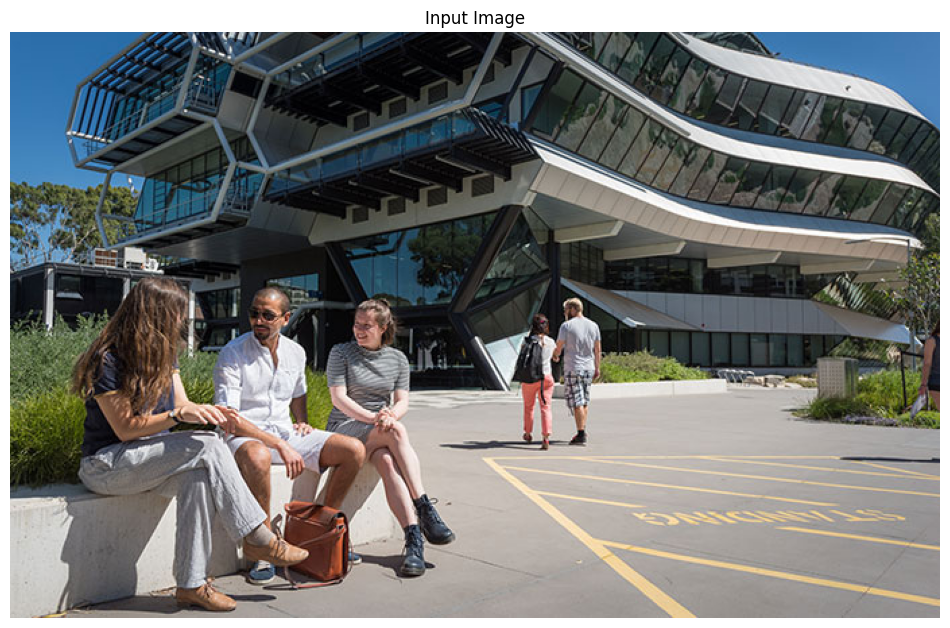

In [25]:
# Image URL
image_url = "https://www.monash.edu/__data/assets/image/0006/959496/clayton-campus-green-chemical-futures-building-exterior2017.jpg"


# Load the image
with open("image.jpg", "rb") as f:
    image = Image.open(f).convert("RGB")


# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.title("Input Image")
plt.show()

### YOLO (You Only Look Once)

We will use a SOTA version of the **YOLO (You Only Look Once)** model for object detection using Hugging Face’s `transformers` library. YOLO is one of the most efficient models for real-time object detection and has been adapted for several applications. Here, we will use the **YOLOS** model, which is a Vision Transformer (ViT) based variant of YOLO, designed for object detection tasks (don't worry, in the next few weeks we will learn about vision transformers).

HuggingFace transformer library provides us with a simple and easy-to-use interface to load and use pre-trained models. To load the YOLOS model, we can use the `YolosForObjectDetection` class from the `transformers` library. This class provides a simple API to load the pre-trained YOLOS model and perform object detection on images. We also need to load the associated image processor to handle all preprocessing tasks such as resizing and normalizing the input images to the correct format. This can be done using the `YolosImageProcessor` class.

Do not forget to install the `transformers` library before running the code. You can install it using the following command:
```bash
pip install transformers
```

In [26]:
from transformers import YolosForObjectDetection, YolosImageProcessor


# Load the pre-trained model and image processor
model_name = "hustvl/yolos-small"

# Load the model
yolo_model = YolosForObjectDetection.from_pretrained(model_name)

# Load the image processor
yolo_processor = YolosImageProcessor.from_pretrained(model_name)

# Set the model to evaluation mode
yolo_model.eval()

/home/lucas/code/ece4179-neural-networks/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


YolosForObjectDetection(
  (vit): YolosModel(
    (embeddings): YolosEmbeddings(
      (patch_embeddings): YolosPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (interpolation): InterpolateInitialPositionEmbeddings()
    )
    (encoder): YolosEncoder(
      (layer): ModuleList(
        (0-11): 12 x YolosLayer(
          (attention): YolosAttention(
            (attention): YolosSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): YolosSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
        

Now study the snippet below to understand how you can use the YOLOS model for object detection. 

```python


In [27]:
inputs = yolo_processor(images=image, return_tensors="pt")
# Perform inference
with torch.inference_mode():
    outputs = yolo_model(**inputs)

# Extract logits and bounding boxes
logits = outputs.logits.squeeze().cpu()  # Classification scores
pred_boxes = outputs.pred_boxes.squeeze().cpu()  # Predicted bounding boxes

### The COCO Dataset
Object detection models are often trained using the Microsoft [Common Objects in Context (COCO)](https://cocodataset.org/#home) dataset. While the COCO dataset is known for its 80 common object classes (such as **person**, **car**, and **dog**), it actually contains 91 total object classes in its full version. This includes 11 additional supercategories or background classes used for specific tasks or to represent the absence of objects.

The YOLOS model is trained on the full COCO dataset and can generate logits for all 91 classes. When you examine the model's output, you may encounter "N/A" labels. These "N/A" labels are part of the expanded class set, but typically don't correspond to meaningful object detections in standard scenarios.

<div style="text-align: center;">
    <img src="data/coco_teaser.jpg" alt="COCO Dataset Teaser" width="80%">
</div>

In [28]:
# Retrieve class names directly from the model configuration
class_names = yolo_model.config.id2label

# Display the list of class names (COCO classes)
for idx, class_name in class_names.items():
    print(f"{idx}: {class_name}")

0: N/A
1: person
2: bicycle
3: car
4: motorcycle
5: airplane
6: bus
7: train
8: truck
9: boat
10: traffic light
11: fire hydrant
12: N/A
13: stop sign
14: parking meter
15: bench
16: bird
17: cat
18: dog
19: horse
20: sheep
21: cow
22: elephant
23: bear
24: zebra
25: giraffe
26: N/A
27: backpack
28: umbrella
29: N/A
30: N/A
31: handbag
32: tie
33: suitcase
34: frisbee
35: skis
36: snowboard
37: sports ball
38: kite
39: baseball bat
40: baseball glove
41: skateboard
42: surfboard
43: tennis racket
44: bottle
45: N/A
46: wine glass
47: cup
48: fork
49: knife
50: spoon
51: bowl
52: banana
53: apple
54: sandwich
55: orange
56: broccoli
57: carrot
58: hot dog
59: pizza
60: donut
61: cake
62: chair
63: couch
64: potted plant
65: bed
66: N/A
67: dining table
68: N/A
69: N/A
70: toilet
71: N/A
72: tv
73: laptop
74: mouse
75: remote
76: keyboard
77: cell phone
78: microwave
79: oven
80: toaster
81: sink
82: refrigerator
83: N/A
84: book
85: clock
86: vase
87: scissors
88: teddy bear
89: hair dr

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">

### <span style="color: pink;">Task #1. Understanding YOLO's output</span>  

The output of the YOLOS model consists of two main components: **logits** and **bounding boxes**. The logits represent the model's scores for each object class, while the bounding boxes provide the spatial locations of the detected objects. Use softmax function to convert the logits into probabilities and print out their values along with the bounding boxes. Use the provided code snippet to draw the bounding boxes on the image.



</div>

In [29]:
# Apply softmax to the logits to get class probabilities
softmax_probs = F.softmax(logits, dim=0)

# Get the class ID with the highest probability (maximum softmax value)
max_class_ids = softmax_probs.max(dim=1).indices
max_probs = softmax_probs.max(dim=1).values

# Ensure tensors are on CPU and convert to lists for pandas
max_class_ids = max_class_ids.tolist()  # Convert to a list for easy handling
max_probs = max_probs.tolist()  # Convert to a list for easy handling
pred_boxes = pred_boxes.tolist()  # Convert bounding boxes to a list

# Create a DataFrame for better visualization, formatting to 2 decimal points
df = pd.DataFrame(
    {
        "Pred_Class_ID": max_class_ids,  # Class ID with the highest softmax probability
        "Max_Probability": [
            f"{prob:.2f}" for prob in max_probs
        ],  # Format probability to 2 decimal points
        "BB_xmin": [
            f"{box[0]:.2f}" for box in pred_boxes
        ],  # xmin of the bounding boxes, formatted
        "BB_ymin": [
            f"{box[1]:.2f}" for box in pred_boxes
        ],  # ymin of the bounding boxes, formatted
        "BB_xmax": [
            f"{box[2]:.2f}" for box in pred_boxes
        ],  # xmax of the bounding boxes, formatted
        "BB_ymax": [
            f"{box[3]:.2f}" for box in pred_boxes
        ],  # ymax of the bounding boxes, formatted
    }
)

# Print the DataFrame
print(df)

    Pred_Class_ID Max_Probability BB_xmin BB_ymin BB_xmax BB_ymax
0               1            0.19    0.34    0.68    0.24    0.50
1              15            0.54    0.17    0.83    0.31    0.34
2              91            0.00    0.76    0.58    0.03    0.03
3              20            0.01    0.82    0.60    0.03    0.02
4              85            0.08    0.19    0.66    0.06    0.03
..            ...             ...     ...     ...     ...     ...
95             70            0.22    0.35    0.82    0.17    0.24
96             32            0.00    0.59    0.55    0.02    0.07
97              1            0.03    0.27    0.57    0.10    0.24
98             44            0.01    0.60    0.62    0.02    0.04
99              1            0.04    0.58    0.54    0.03    0.11

[100 rows x 6 columns]


Let us plot the predicted bounding boxes on an image using the YOLOS model. Run the cell below and examine the output.

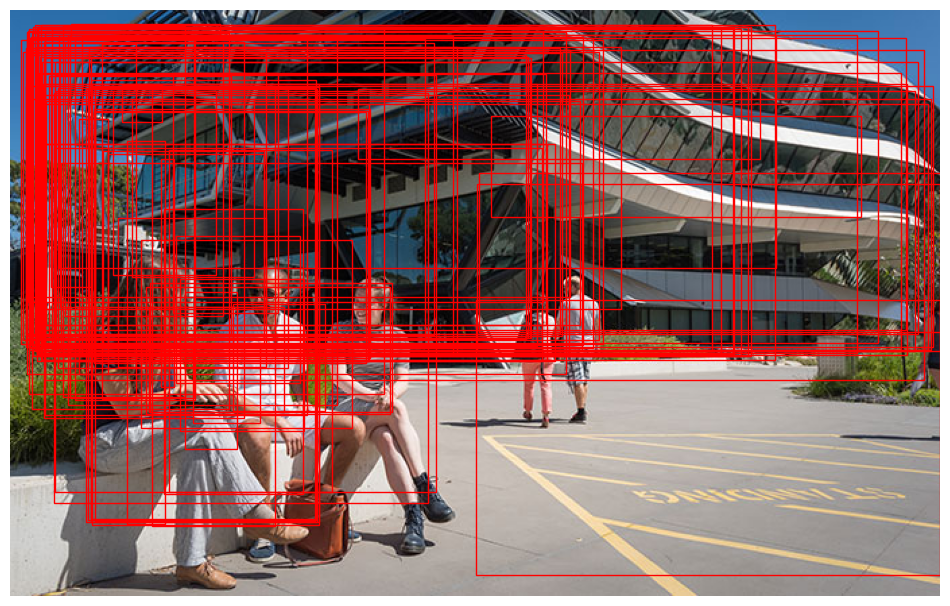

In [30]:
# Get the dimensions of the image
image_width, image_height = image.size


fig, ax = plt.subplots(1, figsize=(12, 8))  # Set the figsize directly in plt.subplots
ax.imshow(image)  # Display the image

# Draw bounding boxes on the image
for i, box in enumerate(pred_boxes):
    # Bounding box coordinates (normalized, so we scale them to the image size)
    xmin = box[0] * image_width
    ymin = box[1] * image_height
    xmax = box[2] * image_width
    ymax = box[3] * image_height
    width = xmax - xmin
    height = ymax - ymin

    # Create a red rectangle for each bounding box
    rect = patches.Rectangle(
        (xmin, ymin), width, height, linewidth=1, edgecolor="red", facecolor="none"
    )

    # Add the rectangle to the plot
    ax.add_patch(rect)

# Display the plot with bounding boxes
ax.axis("off")  # Turn off the axis
plt.show()

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">

### <span style="color: pink;">Task #2. Understanding YOLO's output</span>  
The `YolosImageProcessor` class provides a method called `post_process_object_detection` that processes the raw output of the YOLOS model and generates meaningful bounding boxes for detected objects. This method returns a list of dictionaries, where each dictionary contains the following keys:

- **`label`**: The predicted class label of the detected object, represented as an integer corresponding to the object category.
- **`score`**: The confidence score of the detection, indicating how certain the model is about the presence of the object.
- **`box`**: The bounding box coordinates of the detected object in the format `[xmin, ymin, xmax, ymax]`, representing the object's location in the image.


To apply post-processing to the YOLOS model's output, you need to provide a **confidence threshold** to determine which detections are kept. This threshold filters out detections with confidence scores below the specified value. For example, in the code below, we set a threshold of **80%** confidence:

```python
# Post-process the outputs
results = yolo_processor.post_process_object_detection(
    outputs,                   # Raw model outputs (logits, bounding boxes)
    threshold=0.8,             # Confidence threshold for detections (filter out scores below 0.8)
    target_sizes=target_sizes  # The size of the original image, used to scale the bounding boxes
)[0]
```

</div>

{'scores': tensor([0.9764, 0.9837, 0.9815, 0.7134, 0.9975, 0.8919, 0.5154, 0.7200, 0.5133,
        0.9887, 0.9909, 0.9348, 0.6450, 0.6978, 0.9983, 0.8825, 0.8797, 0.5637,
        0.7274, 0.9109, 0.7183, 0.6033, 0.9637, 0.9617, 0.5466, 0.6785, 0.8491]), 'labels': tensor([ 1,  3,  3,  8,  3, 64,  8,  8,  3,  2,  3,  8,  8, 64,  3,  8,  3,  1,
        64, 64,  8,  3,  3,  3, 64,  3,  3]), 'boxes': tensor([[ 1.5950e+02,  1.4264e+02,  3.0183e+02,  4.0239e+02],
        [ 8.0212e+01,  2.2222e+02,  1.1436e+02,  3.0052e+02],
        [ 7.5248e+02,  1.9656e+02,  8.7175e+02,  3.4994e+02],
        [ 7.4611e+02,  1.9190e+02,  8.7232e+02,  3.4869e+02],
        [ 2.9044e+02,  2.1154e+02,  4.6460e+02,  3.5370e+02],
        [ 2.7162e+02,  2.4067e+02,  3.3973e+02,  3.3017e+02],
        [ 1.2160e+02,  8.8614e+01,  2.5801e+02,  2.2307e+02],
        [-5.6588e-02,  1.5511e+02,  9.2243e+01,  3.5523e+02],
        [ 4.2022e+02,  2.2385e+02,  4.6524e+02,  2.6093e+02],
        [ 2.0343e+02,  3.1259e+02,  2.7090e+

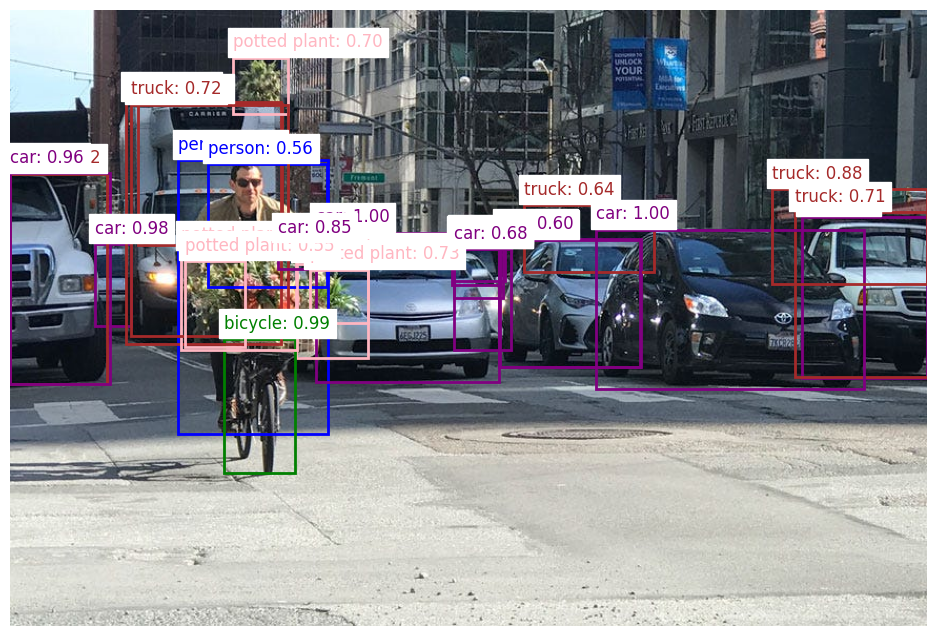

{1: 1, 3: 1, 8: 1, 64: 1, 2: 1}


In [49]:
# Post-process the outputs
results = yolo_processor.post_process_object_detection(
    outputs, threshold=0.5, target_sizes=torch.tensor([image2.size[::-1]])
)[0]
print(results)


# Plot the detection results
class_names = yolo_model.config.id2label
plot_results(image2, results, class_names)
s = dict()
for r in results["labels"].tolist():
    s[r] = 1
print(s)

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">

### <span style="color: pink;">Task #3. YOLO can see things</span>  

Now study what YOLOs can detect by changing the confidence threshold. Try different values between **0.1** and **0.9** to see how the model's predictions change. Also try different images to see how the model performs on various scenes. In particular, try this [image](https://miro.medium.com/v2/resize:fit:1400/1*EYFejGUjvjPcc4PZTwoufw.jpeg) to see how the model performs on a complex scene.

</div>

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">

### <span style="color: pink;">Task #4. YOLO on your webcam!</span>  

You can also use the YOLOS model to perform object detection on live video streams from your webcam. To do this, we will use the VideoCapture class from the OpenCV library to capture frames from the webcam and display the detected objects in real-time. Feel free to walk around and see how the model performs on different objects and scenes.



</div>

In [ ]:
# Open the webcam (use 0 for the default camera)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Function to process frames and apply YOLO
def process_frame(frame):
    # Convert the frame (BGR) to PIL Image (RGB)
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Preprocess the image for YOLO model
    inputs = yolo_processor(images=image, return_tensors="pt")

    # Perform inference with the YOLO model
    with torch.no_grad():
        outputs = yolo_model(**inputs)

    # Post-process the outputs with a confidence threshold
    frame_height, frame_width = frame.shape[:2]
    target_sizes = torch.tensor([[frame_height, frame_width]])
    results = yolo_processor.post_process_object_detection(outputs, 
                                                           threshold= , #<--- YOUR CODE HERE --->
                                                           target_sizes=target_sizes)[0]

    # Use the plot_results function to draw bounding boxes and return the frame with bounding boxes
    frame_with_boxes = plot_results(np.array(image), results, yolo_model.config.id2label, show=False)

    # Convert the frame from RGB back to BGR for OpenCV
    return cv2.cvtColor(frame_with_boxes, cv2.COLOR_RGB2BGR)

# Real-time video capture and processing loop
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Process the current frame with YOLO
    processed_frame = process_frame(frame)

    # Display the processed frame
    cv2.imshow('YOLO Object Detection', processed_frame)

    # Press 'q' to quit the video stream
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()


### Contrastive Learning of Image and Text Representations (CLIP)

State-of-the-art (SOTA) computer vision systems are trained to predict a fixed set of predetermined object categories. This restricted form of supervision hampers their versatility as new labels are required for recognizing any other concepts. An emerging solution is to train models using text descriptions of images. This offers a more expansive supervisory signal. [CLIP](https://openai.com/research/clip), a foundation model from OpenAI, shows that matching captions with images can effectively produce SOTA image representation from scratch. Similar to other foundation models such as GPT family, CLIP is trained on a very large scale dataset (400M image-text pairs) and can be used for a variety of vision and language tasks. 

By matching text descriptions of images to their visual information, CLIP learns associations between the language and vision.  Below, we check the vision models provided by OpenAI and opt for using a simple ResNet model (a CNN). CLIP comes with bigger and more powerful vision encoders such as Vision Transformer (ViT) (eg., ViT-L/14). Feel free to investigate those models as well.

### Exploring CLIP Model Properties

Let's understand the properties of the CLIP model. We'll load the model and examine various key attributes, such as:

- **Model Parameters**: The total number of trainable parameters.
- **Input Resolution**: The dimensions the input image should be resized to.
- **Context Length**: The maximum sequence length for text inputs.
- **Vocabulary Size**: The size of the vocabulary the model was trained on.

We'll also break down the model parameters into its vision and language components to get a deeper understanding of its architecture. We note that the vision component (ViT) has $87,456,000/151,277,313 \approx 57.8\%$ of the parameters, while the language component (transformer + token_embedding) has $63,690,241/151,277,313 \approx 42.2\%$ of the parameters. Study the code below to understand how the model is loaded and how the parameters are counted.

In [ ]:
from transformers import CLIPProcessor, CLIPModel

# Load the ViT-based CLIP model and processor from Hugging Face
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


clip_model.to(device).eval()  # Move the model to the device

# Fetch the input resolution for visual inputs
input_resolution = clip_model.config.vision_config.image_size
print(f"Input resolution: {input_resolution}")

# Fetch the maximum sequence length for textual inputs (context length)
context_length = clip_model.config.text_config.max_position_embeddings
print(f"Context length: {context_length}")

# Fetch the vocabulary size of the model
vocab_size = clip_model.config.text_config.vocab_size
print(f"Vocab size: {vocab_size}")

# Calculate and print the total number of model parameters
total_params = sum(p.numel() for p in clip_model.parameters())
print(f"Model parameters: {total_params:,}")

# Calculate the number of parameters for the vision model
vision_params = sum(p.numel() for p in clip_model.vision_model.parameters())
print(f"Vision parameters: {vision_params:,}")

# Calculate the number of parameters for the language model
language_params = total_params - vision_params
print(f"Language parameters: {language_params:,}")

### Language Tokenization in CLIP

CLIP incorporates a built-in language model for text processing. The first step in handling text is tokenization, where sentences are converted into a sequence of tokens according to a pre-defined vocabulary. The CLIP model uses a [byte-pair encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding) (BPE) vocabulary with 49408 tokens. BPE is a simple data compression technique that iteratively replaces the most frequent pair of bytes in a sequence with a single, unused byte. This process is repeated until the vocabulary size reaches a pre-defined limit. The BPE vocabulary used by CLIP is trained on a large corpus of text from the web. The vocabulary is case-sensitive and includes some special tokens. 

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #5. Tokenization</span>  

In the following code, observe how different inputs are tokenized. Do any patterns emerge?

</div>


In [ ]:
clip_tokenizer = clip_processor.tokenizer


text = "Hello"
tokens = clip_tokenizer(text, return_tensors="pt")["input_ids"].numpy()
print(f"Tokenizing '{text}': {tokens}\n")


text = "Hello World"
tokens = clip_tokenizer(text, return_tensors="pt")["input_ids"].numpy()
print(f"Tokenizing '{text}': {tokens}\n")


text = "Hello ECE4179!"
tokens = clip_tokenizer(text, return_tensors="pt")["input_ids"].numpy()
print(f"Tokenizing '{text}': {tokens}\n")

### Zero-Shot Classification

Zero-Shot (ZS) classification is the task of classifying samples into classes that are not seen during training. How is it even possible? Unlike traditional machine learning models that require labeled examples for each class they identify, ZS models generalize to unseen classes by leveraging semantic information. Training ZS models can be done by learning to associate attributes/semantics with data samples. For example, consider describing animals as a way to describe them. You can go on and describe a cat as an animal with four legs, fur, and whiskers. This description can be used to identify a puma even if you have never seen one before. For VLMs, the semantic information is provided by the text descriptions of images.


Now, let's have some fun. Remember the main characters from the movie Guardians of the Galaxy? They are Peter Quill (starlord), Gamora, Drax, Rocket, and Groot. Let's see if CLIP can recognize them. First, let's create appropriate prompts for them. We will use the following prompts:
"this is a photo of {character_name}, a character from the movie Guardians of the Galaxy"
where {character_name} is one of the characters mentioned above. For example, the prompt for Peter Quill is "this is a photo of Rocket, a character from the movie Guardians of the Galaxy" 

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #6. Recognize characters from Guardians of the Galaxy - Text Encoder</span>
Use the text encoder to define class prototypes for each character. The class prototype in our case is the text embedding of prompts for each character. 
</div>

In [ ]:
character_names = ["Peter Quill", "Gamora", "Drax", "Rocket", "Groot"]
text_prompts = #<--- YOUR CODE HERE --->


with torch.inference_mode():
    # Text features
    inputs = clip_processor(text= #<--- YOUR CODE HERE --->
    text_features = clip_model.get_text_features(**inputs)
    
    
text_features.shape

I have downloaded two images for each character. Run the following code to see these images.

In [ ]:
image_names = [f"galaxy{i}.jpg" for i in range(1, 11)]

# Read images from the data folder and convert them to PIL images
images = [Image.open(f"data/{image_name}") for image_name in image_names]

# Plot the images
fig, axs = plt.subplots(2, 5, figsize=(20, 4))

for i, (img, ax) in enumerate(zip(images, axs.ravel())):
    ax.imshow(img)
    ax.axis("off")

plt.show()

The code below extracts the image embeddings using the vision encoder. 

In [ ]:
# Preprocess the images for CLIP using Hugging Face's processor
inputs = clip_processor(images=images, return_tensors="pt").to(device)

# Forward pass through the vision encoder
with torch.inference_mode():
    image_features = clip_model.get_image_features(**inputs)

print(f"Image features shape: {image_features.shape}")

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px; width: 90%; margin: 0 auto; margin-top: 10px;">

### <span style="color: pink;">Task #7. ZSC to categorize characters from Guardians of the Galaxy</span>

In this task, we will implement a zero-shot (ZS) classifier to categorize images of characters from the movie *Guardians of the Galaxy*. The classifier should take a set of image embeddings and compare them to class prototypes generated from text embeddings. By calculating the cosine similarity between each image embedding and all class text embeddings, the classifier will predict the class with the highest similarity as the correct category.
</div>



In [18]:
def zs_classifier(img_embeddings, text_embeddings, k=1):
    """
    Perform zero-shot classification by computing the cosine similarity 
    between image embeddings and text embeddings (class prototypes).
    
    Args:
        img_embeddings (torch.Tensor): The embeddings of the images.
        text_embeddings (torch.Tensor): The embeddings of the text (class prototypes).
        k (int): The number of top classes to return. Defaults to 1 (the most similar class).
    
    Returns:
        sorted_indices (torch.Tensor): The indices of the top-k most similar text embeddings for each image.
        similarity_matrix (torch.Tensor): The cosine similarity matrix between image and text embeddings.
    """
    # Compute the cosine similarity between the image and text embeddings
    similarity_matrix = #<--- YOUR CODE HERE --->

    # Get the indices of the most similar text embeddings for each image
    sorted_indices = #<--- YOUR CODE HERE --->  
    
    return sorted_indices, similarity_matrix


In [ ]:
# Perform zero-shot classification
sorted_indices, similarity_matrix = zs_classifier(image_features, text_features, k=1)

# Print the sorted indices
print(f"Sorted indices:\n{sorted_indices}\n")


similarity_df = pd.DataFrame(similarity_matrix.detach().cpu(), columns=character_names)

# Print the similarity matrix using Pandas DataFrame
print(f"Similarity matrix:\n{similarity_df}\n")

# Initialize a figure for displaying the images and their predicted labels
fig, axs = plt.subplots(2, 5, figsize=(20, 4))

# Loop through each subplot to display the image and predicted label
for i in range(10):
    ax = axs.ravel()[i]  # Get the current subplot
    ax.imshow(images[i])  # Display the image
    idx = sorted_indices[i]  # Get the index of the predicted label
    ax.set_title(
        f"Prediction: {character_names[idx]}"
    )  # Set the title as the predicted label
    ax.axis("off")  # Turn off axis

# Show the entire plot
plt.show()

### Where is the yellow cab?

Now that we have learned about CLIP and its ZSL capabilities, let's see if we can use it to analyze videos. We will use the [dashcam video](https://www.youtube.com/watch?v=PGMu_Z89Ao8), which is captured by driving around San Francisco. I have taken the liberty and extracted the first 20min of this video to make it easier to work with. Below, we will use the opencv library to read the video frame by frame. We will then use CLIP to recognize the objects in each frame. 

In [ ]:
# Initialize VideoCapture
video = cv2.VideoCapture("data/dashcam.mp4")

# Get number of frames
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Get frame rate
fps = int(video.get(cv2.CAP_PROP_FPS))

# Get frame resolution
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Number of Frames: {frame_count}")
print(f"Frame Rate: {fps} FPS")
print(f"Frame Resolution: {frame_width}x{frame_height}")

# Release the VideoCapture
video.release()

We will use the python function 

``` python
    read_video_frames(filename, stride=N)
```
to read the video by striding every N frames. This will help us to speed up the process. The function returns a list of frames. 

In [21]:
def read_video_frames(filename, stride=16):
    """
    Reads frames from a video file at a specified stride and converts them to PIL images.

    Args:
        filename (str): The path to the video file to read frames from.
        stride (int): The number of frames to skip between each saved frame (default is 16).
                      For example, a stride of 16 means that every 16th frame will be saved.

    Returns:
        List[PIL.Image.Image]: A list of PIL Image objects representing the selected video frames.
    """

    # The frame images will be stored in video_frames
    video_frames = []

    # Open the video file
    video = cv2.VideoCapture(filename)
    fps = video.get(cv2.CAP_PROP_FPS)

    current_frame = 0
    while video.isOpened():
        # Read the current frame
        ret, frame = video.read()

        # Convert it to a PIL image (required for CLIP) and store it
        if ret == True:
            video_frames.append(Image.fromarray(frame[:, :, ::-1]))
        else:
            break

        # Skip N frames
        current_frame += stride  # skip every Nth frame
        video.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

    video.release()
    return video_frames

In [ ]:
# Read frames and skip every 16 frames (roughly every 500msec)
frame_stride = 16
video_frames = read_video_frames("data/dashcam.mp4", stride=frame_stride)

# Print the number of frames that were read
print(f"Frames extracted: {len(video_frames)}")

To facilitate the future tasks, we can extract the features of the frames using the CLIP model and store them in the memory. This will help us to avoid re-computing the features every time we run the code. The cell below will do the job for you.

In [ ]:
# We put the frames into batches of size 100 and process them in parallel
batch_size = 100
number_batches = int(np.ceil(len(video_frames) / batch_size))

video_features = []

# Process each batch
for i in range(number_batches):
    print(f"Processing batch {i+1}/{number_batches}")

    # Get the relevant frames
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(video_frames))
    batch_frames = video_frames[start_idx:end_idx]

    # Preprocess the frames for the batch using Hugging Face's processor
    batch_preprocessed = clip_processor(images=batch_frames, return_tensors="pt").to(
        device
    )

    # Encode the images with CLIP and normalize
    with torch.inference_mode():
        batch_features = clip_model.get_image_features(**batch_preprocessed)
        batch_features /= batch_features.norm(dim=-1, keepdim=True)

    # Append the batch features to the list containing all features
    video_features.append(batch_features)

# Concatenate the batch features along the batch dimension
video_features = torch.cat(video_features, dim=0)

# Print some stats
print(f"Features: {video_features.shape}")

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #8. Can you find yellow cabs?</span>

In this task, you will use the extracted features of the frames to find the frames where a yellow cab is present. You can use a prompt like "this is a photo of a yellow cab" or something more specific. Can you also find

1.  people crossing the street
2.  trams
3.  fire trucks
4.  bridges
5.  a car that is parked on the sidewalk
</div>

In [24]:
def search_video(search_query, video_features, top_k=4):
    """
    Search a video for frames that match a given search query using a CLIP model.

    Args:
        search_query (str): Text query to search for.
        video_features (torch.Tensor): Precomputed features for the video frames.
        top_k (int): Number of top results to return.
        min_frame_distance (int): Minimum distance between selected frames to avoid nearby frames.

    Returns:
        top_k_indices (list): List of indices of the top-k selected frames.
    """
    # Tokenize and encode the search query
    inputs = clip_processor(text=[search_query], return_tensors="pt", padding=True).to(
        device
    )
    with torch.inference_mode():
        text_features = clip_model.get_text_features(**inputs)

    # Compute cosine similarity between video features and text features
    similarity_matrix = F.cosine_similarity(
        torch.tensor(video_features), torch.tensor(text_features), dim=-1
    )

    # Sort the similarity matrix to find the best matching frames
    top_k_indices = (
        torch.argsort(similarity_matrix, dim=0, descending=True)[:top_k].cpu().numpy()
    )
    top_k_scores = similarity_matrix[top_k_indices].cpu().numpy()

    return top_k_indices, top_k_scores

In [ ]:
search_query = #<--- YOUR CODE HERE --->
top_k =  #<--- YOUR CODE HERE --->

top_k_indices, top_k_scores = search_video(search_query, video_features, top_k=top_k)



# Now you can visualize the selected frames along with their similarity scores
fig, axes = plt.subplots(nrows=2, ncols=top_k // 2, figsize=(12, 6))

# Loop through and display the best matching frames
for i in range(len(top_k_indices)):
    frame_id = top_k_indices[i]
    ax = axes.ravel()[i]
    
    # Display the frame
    ax.imshow(video_frames[frame_id])
    ax.axis('off')

    # Calculate timestamp in the video (if necessary)
    seconds = round(frame_id * frame_stride / fps)
    
    # Set title with timestamp and similarity score
    similarity_score = f"Sim: {top_k_scores[i]:.2f}"
    ax.set_title(f"Found at {str(datetime.timedelta(seconds=seconds))}\n{similarity_score}")

plt.tight_layout()
plt.show()


### Zero-shot Object Detection

Zero-shot object detection (ZSD) is the task of detecting objects in images without any training data for the specific object classes. ZSD models are trained on a set of known object classes and can generalize to unseen classes by leveraging semantic information. The CLIP model can be used for ZSD by providing text descriptions of objects as prompts. The model can then predict the presence of objects in images based on the similarity between the image features and the text embeddings of the object descriptions. We will use the OWL-ViT model, which uses the CLIP as the backbone for object detection. You need to install the scipy library to run the code below. You can install it using the following command:

```bash
pip install scipy
```

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

checkpoint = "google/owlv2-base-patch16-ensemble"

owl_model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
owl_processor = AutoProcessor.from_pretrained(checkpoint)

owl_model.to(device).eval()

<div style="background-color: #2b0080; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #9. Can you find the NASA badge?</span>

In this task, you will use the OWL-ViT model to perform zero-shot object detection on an image containing various objects. You will provide a prompt describing the object you want to detect (e.g., "nasa badge") and use the model to predict the presence of the object in the image. Can you find all the faces, rockets, banners, and nasa badges in the image?
</div>

In [27]:
# Load the image from the data folder
image = Image.open("data/astronaut.png").convert("RGB")

# Corrected typo for owl_processor
text_queries = #<--- YOUR CODE HERE --->
owl_inputs = owl_processor(text=text_queries, images=image, return_tensors="pt").to(device)

# Inference mode
with torch.inference_mode():
    owl_outputs = owl_model(**owl_inputs)

# Ensure target_sizes is in the correct shape (batch, height, width)
target_sizes = torch.tensor([image.size[::-1]])
owl_results = owl_processor.post_process_object_detection(owl_outputs, threshold=0.25, target_sizes=target_sizes)[0]


In [ ]:
plot_results(image, owl_results, class_names=text_queries)

### References:
1. Carion, N., et al. "End-to-End Object Detection with Transformers." [DETR Paper](https://arxiv.org/abs/2005.12872)
2. Radford, A., et al. "Learning Transferable Visual Models From Natural Language Supervision." [CLIP Paper](https://arxiv.org/abs/2103.00020)
3. Minderer, M., et al. "Simple Open-Vocabulary Object Detection with Vision Transformers." [OWL-ViT Paper](https://arxiv.org/abs/2205.06230)
